# Install libraries 

In [ ]:
!pip install --upgrade open_spiel --quiet
!apt install libgraphviz-dev --quiet
!pip install pygraphviz --quiet

     |████████████████████████████████| 4.4 MB 4.4 MB/s 
     |████████████████████████████████| 38.1 MB 34.1 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
Reading package lists...
Building dependency tree...
Reading state information...
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'apt autoremove' to remove them.
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk libxdot4
0 upgraded, 8 new

# Import libraries

In [ ]:
"""Policy gradient agents trained and evaluated on Kuhn Poker."""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from absl import app
from absl import flags
from absl import logging

from matplotlib import pyplot as plt

import numpy as np

import tensorflow.compat.v1 as tf

from open_spiel.python import policy
from open_spiel.python import rl_environment
from open_spiel.python.algorithms import exploitability
from open_spiel.python.algorithms import policy_gradient
from open_spiel.python.algorithms import dqn

# FLAGS = flags.FLAGS

# flags.DEFINE_integer("num_episodes", int(1e6), "Number of train episodes.")
# flags.DEFINE_integer("eval_every", int(1e4), "Eval agents every x episodes.")
# flags.DEFINE_enum("loss_str", "rpg", ["a2c", "rpg", "qpg", "rm"],
#                   "PG loss to use.")

Instructions for updating:
non-resource variables are not supported in the long term


# Joint policy for exploitability and nash convergence evaluation

In [ ]:
class JointPolicy(policy.Policy):
  """Joint policy to be evaluated."""

  def __init__(self, env, nfsp_policies):
    game = env.game
    player_ids = [0, 1]
    super(JointPolicy, self).__init__(game, player_ids)
    self._policies = nfsp_policies
    self._obs = {"info_state": [None, None], "legal_actions": [None, None]}

  def action_probabilities(self, state, player_id=None):
    cur_player = state.current_player()
    legal_actions = state.legal_actions(cur_player)

    self._obs["current_player"] = cur_player
    self._obs["info_state"][cur_player] = (
        state.information_state_tensor(cur_player))
    self._obs["legal_actions"][cur_player] = legal_actions

    info_state = rl_environment.TimeStep(
        observations=self._obs, rewards=None, discounts=None, step_type=None)

    p = self._policies[cur_player].step(info_state, is_evaluation=True).probs
    prob_dict = {action: p[action] for action in legal_actions}
    return prob_dict

# Train 2 agents to play Kuhn poker

In [ ]:
num_episodes = int(2 * 1e6)
save_every = int(1e4)

num_players = 2
game_name = "kuhn_poker"
env_configs = {"players": num_players}
env = rl_environment.Environment(game_name, **env_configs)
info_state_size = env.observation_spec()["info_state"][0]
num_actions = env.action_spec()["num_actions"]

rl_algo = "PolicyGradient" #"DQN"
checkpoint_dir = "/content/" + rl_algo.replace(' ', '_').lower() + "_agents"


sess = tf.Session()
# with tf.Session() as sess:
  # pylint: disable=g-complex-comprehension

loss_str = ""
if rl_algo == "PolicyGradient":
    loss_str =  "rpg"
    agents = [
        policy_gradient.PolicyGradient(
            sess,
            idx,
            info_state_size,
            num_actions,
            loss_str=loss_str,
            hidden_layers_sizes=[64, 32], #(128,),
            batch_size=64, #32, #16,
            critic_learning_rate=0.1,#0.01,
            pi_learning_rate=0.01,#0.001,
            entropy_cost=0.01,
            num_critic_before_pi=8,
            additional_discount_factor=1.0,
            max_global_gradient_norm=3,
            optimizer_str="sgd") for idx in range(num_players)
    ]
    expl_policies_avg = JointPolicy(env, agents)
elif rl_algo == "DQN":
    loss_str = "mse" # "huber"
    agents = [
        dqn.DQN(
            sess,
            player_id=idx,
            state_representation_size=info_state_size,
            num_actions=num_actions,
            loss_str=loss_str, 
            hidden_layers_sizes=[64, 32], #128, [256, 128]
            replay_buffer_capacity=10000,
            batch_size=128,
            learning_rate=0.01,
            update_target_network_every=1000,
            learn_every=10,
            discount_factor=1.0,
            min_buffer_size_to_learn=1000,
            epsilon_start=1.0,
            epsilon_end=0.1,
            epsilon_decay_duration=int(1e6),
            optimizer_str="sgd") for idx in range(num_players)
    ]
    expl_policies_avg = JointPolicy(env, agents)


sess.run(tf.global_variables_initializer())

losses_list = []
expl_list = []
nash_list = []
best_nash = 1

for ep in range(num_episodes):

  if ((ep + 1) % save_every == 0):
    losses = [agent.loss for agent in agents]
    expl = exploitability.exploitability(env.game, expl_policies_avg)
    nash = exploitability.nash_conv(env.game, expl_policies_avg)

    losses_list.append(losses)
    expl_list.append(expl)
    nash_list.append(nash)

    # if nash < best_nash: # if nash convergence has improved, save each agent
    #   best_nash = nash
    #   for agent in agents:
    #     agent.save(checkpoint_dir)

    msg = "-" * 80 + "\n"
    msg += "ep:{}:\n expl={}\n nash_conv={}\n losses={}\n".format(ep + 1, expl, nash, losses)
    print(msg)

  time_step = env.reset()
  while not time_step.last():
    player_id = time_step.observations["current_player"]
    agent_output = agents[player_id].step(time_step)
    action_list = [agent_output.action]
    time_step = env.step(action_list)
  

  # Episode is over, step all agents with final info state.
  for agent in agents:
    agent.step(time_step)

--------------------------------------------------------------------------------
ep:10000:
 expl=0.5100638397790892
 nash_conv=1.0201276795581784
 losses=[(1.2340932, 0.3541698), (0.9852817, 0.6684813)]

--------------------------------------------------------------------------------
ep:20000:
 expl=0.3806775111293315
 nash_conv=0.761355022258663
 losses=[(1.3525062, 0.34592605), (0.6203575, 0.58867645)]

--------------------------------------------------------------------------------
ep:30000:
 expl=0.2983007544155588
 nash_conv=0.5966015088311176
 losses=[(0.93900543, 0.2241491), (1.1771353, 0.4802782)]

--------------------------------------------------------------------------------
ep:40000:
 expl=0.2729543372920076
 nash_conv=0.5459086745840152
 losses=[(1.2978699, 0.20157824), (0.6736773, 0.41621646)]

--------------------------------------------------------------------------------
ep:50000:
 expl=0.2574341328551989
 nash_conv=0.5148682657103978
 losses=[(1.5127287, 0.12522718), 

# Restore saved agents
(does not work unfortunately ...)

In [ ]:
# # Restore agents from checkpoint (does not work unfortunately ...)
# agents = []
# if rl_algo == "PolicyGradient":
#   agents = [policy_gradient.PolicyGradient(sess,
#                                           idx,
#                                           info_state_size,
#                                           num_actions,
#                                           loss_str="rpg",
#                                           hidden_layers_sizes=(128,)).restore(checkpoint_dir) 
#                                           for idx in range(num_players)]
# elif rl_algo == "DQN":
#   agents = [dqn.DQN(
#             sess,
#             player_id=idx,
#             state_representation_size=info_state_size,
#             num_actions=num_actions,
#             loss_str="mse", # "huber"
#             hidden_layers_sizes=128,
#             replay_buffer_capacity=10000).restore(checkpoint_dir) 
#             for idx in range(num_players)]

# Plot Results

In [ ]:
rl_algo.replace(' ', '_').lower()

'policygradient'

In [ ]:
figsize = (10, 5)
output_dir_prefix = "/content/outputs/"
output_dir = output_dir_prefix + rl_algo.replace(' ', '_').lower()
import os
# Create directories for outputs
if os.path.exists(output_dir_prefix) == False:
  os.mkdir(output_dir_prefix)
if os.path.exists(output_dir) == False:
  os.mkdir(output_dir)

## Exploitability

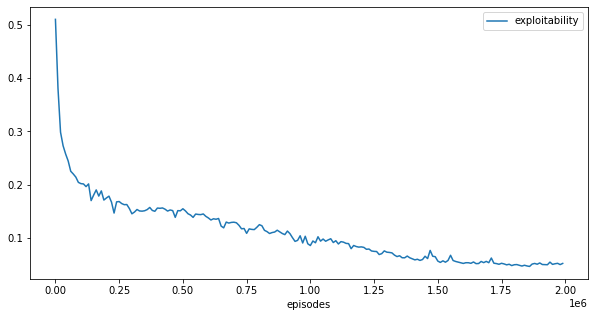

In [ ]:
#fig = 
plt.figure(figsize=figsize)
plt.plot(list(save_every * np.arange(len(expl_list))), expl_list, label = "exploitability")
plt.xlabel("episodes")
plt.legend()
plt.savefig(output_dir + "/exploitability.png")

## Nash Convergence

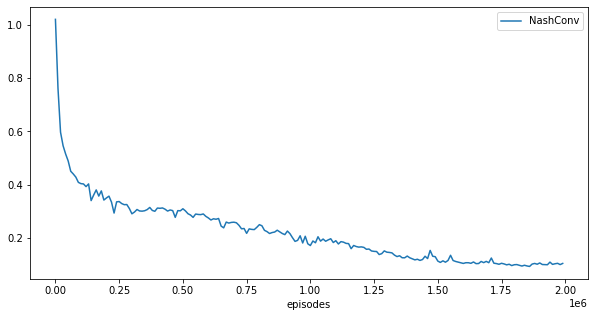

In [ ]:
fig = plt.figure(figsize=figsize)
plt.plot(list(save_every * np.arange(len(nash_list))), nash_list, label = "NashConv")
plt.xlabel("episodes")
plt.legend()
plt.savefig(output_dir + "/nash_conv.png")

## Agent Losses

In [ ]:
agents_dir = output_dir + "/agents";
if os.path.exists(agents_dir) == False:
  os.mkdir(agents_dir)

In [ ]:
if rl_algo != "PolicyGradient":
  fig = plt.figure(figsize=figsize)
  loss_agent0_mse = [loss[0] for loss in losses_list]
  loss_agent1_mse = [loss[1] for loss in losses_list]

  x = list(save_every * np.arange(len(loss_agent0_mse)))
  plt.plot(x, loss_agent0_mse, label = f"Agent 0 - {loss_str} loss")

  x = list(save_every * np.arange(len(loss_agent1_mse)))
  plt.plot(x, loss_agent1_mse, label = f"Agent 1 - {loss_str} loss")
  plt.xlabel("episodes")
  plt.legend()
  plt.savefig(agents_dir + f"/{loss_str}_loss.png")

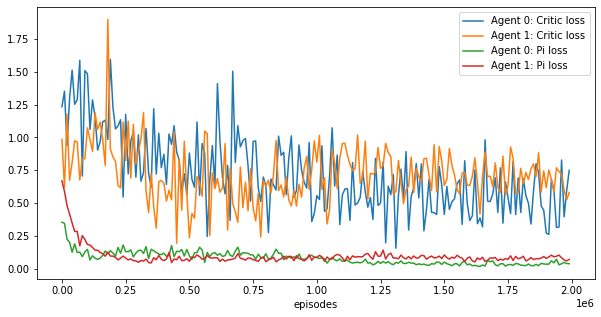

In [ ]:
if rl_algo == "PolicyGradient":
  loss_agent0 = [loss[0] for loss in losses_list]
  loss_agent0_critic = [loss[0] for loss in loss_agent0]
  loss_agent0_pi = [loss[1] for loss in loss_agent0]
  loss_agent1 = [loss[1] for loss in losses_list]
  loss_agent1_critic = [loss[0] for loss in loss_agent1]
  loss_agent1_pi = [loss[1] for loss in loss_agent1]

  x = list(save_every * np.arange(len(loss_agent0)))

  fig = plt.figure(figsize=figsize)
  plt.plot(x, loss_agent0_critic, label = "Agent 0: Critic loss")
  plt.plot(x, loss_agent1_critic, label = "Agent 1: Critic loss")
  plt.plot(x, loss_agent0_pi, label = "Agent 0: Pi loss")
  plt.plot(x, loss_agent1_pi, label = "Agent 1: Pi loss")
    
  plt.xlabel("episodes")
  plt.legend()
  plt.savefig(agents_dir + f"/{loss_str}_losses.png")

In [ ]:
agent0_dir = output_dir + "/agent_0";
if os.path.exists(agent0_dir) == False:
  os.mkdir(agent0_dir)

agent1_dir = output_dir + "/agent_1";
if os.path.exists(agent1_dir) == False:
  os.mkdir(agent1_dir)

In [ ]:
if rl_algo != "PolicyGradient":
  fig = plt.figure(figsize=figsize)
  loss_agent0_mse = [loss[1] for loss in losses_list]

  x = list(save_every * np.arange(len(loss_agent0_mse)))
  plt.plot(x, loss_agent0_mse, label = f"{loss_str} loss")
  plt.xlabel("episodes")
  plt.legend()
  plt.savefig(agent0_dir + f"/{loss_str}_loss.png")

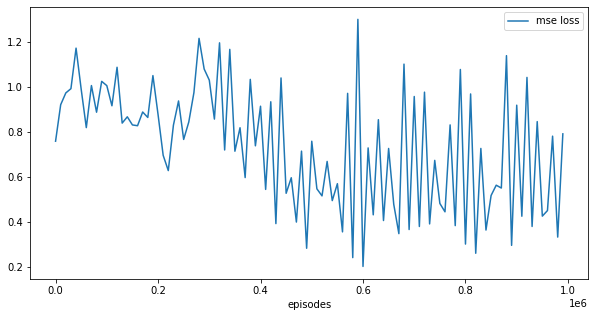

<Figure size 432x288 with 0 Axes>

In [ ]:
if rl_algo != "PolicyGradient":
  fig = plt.figure(figsize=figsize)
  loss_agent1_mse = [loss[0] for loss in losses_list]

  x = list(save_every * np.arange(len(loss_agent1_mse)))
  plt.plot(x, loss_agent1_mse, label = f"{loss_str} loss")
  plt.xlabel("episodes")
  plt.legend()
  plt.savefig(agent1_dir + f"/{loss_str}_loss.png")

In [ ]:
if rl_algo == "PolicyGradient":
  loss_agent0 = [loss[0] for loss in losses_list]
  loss_agent0_critic = [loss[0] for loss in loss_agent0]
  loss_agent0_pi = [loss[1] for loss in loss_agent0]

  x = list(save_every * np.arange(len(loss_agent0)))

In [ ]:
if rl_algo == "PolicyGradient":
  fig = plt.figure(figsize=figsize)
  plt.plot(x, loss_agent0_critic, label = "Critic loss")
  plt.xlabel("episodes")
  plt.legend()
  plt.savefig(agent0_dir + f"/{loss_str}_critic_loss.png")

In [ ]:
if rl_algo == "PolicyGradient":
  fig = plt.figure(figsize=figsize)
  plt.plot(x, loss_agent0_pi, label = "Pi loss")
  plt.xlabel("episodes")
  plt.legend()
  plt.savefig(agent0_dir + f"/{loss_str}_pi_loss.png")

In [ ]:
if rl_algo == "PolicyGradient":
  loss_agent1 = [loss[1] for loss in losses_list]
  loss_agent1_critic = [loss[0] for loss in loss_agent1]
  loss_agent1_pi = [loss[1] for loss in loss_agent1]

  x = list(save_every * np.arange(len(loss_agent1)))

In [ ]:
if rl_algo == "PolicyGradient":
  fig = plt.figure(figsize=figsize)
  plt.plot(x, loss_agent1_critic, label = "Critic loss")
  plt.xlabel("episodes")
  plt.legend()
  plt.savefig(agent1_dir + f"/{loss_str}_critic_loss.png")

In [ ]:
if rl_algo == "PolicyGradient":
  fig = plt.figure(figsize=figsize)
  plt.plot(x, loss_agent1_pi, label = "Pi loss")
  plt.xlabel("episodes")
  plt.legend()
  plt.savefig(agent1_dir + f"/{loss_str}_pi_loss.png")  

## Plot Game Tree

In [ ]:
def _zero_sum_node_decorator(state):
  """Custom node decorator that only shows the return of the first player."""
  attrs = treeviz.default_node_decorator(state)  # get default attributes
  if state.is_terminal():
    attrs["label"] = str(int(state.returns()[0]))
  return attrs


import pyspiel
from open_spiel.python.visualizations import treeviz

game = env.game
game_type = game.get_type()

if game_type.dynamics == pyspiel.GameType.Dynamics.SIMULTANEOUS:
  logging.warn("%s is not turn-based. Trying to reload game as turn-based.", 
               game)
  game = pyspiel.load_game_as_turn_based(game)
  game_type = game.get_type()

if game_type.dynamics != pyspiel.GameType.Dynamics.SEQUENTIAL:
  raise ValueError("Game must be sequential, not {}".format(
      game_type.dynamics))

if (game_type.utility == pyspiel.GameType.Utility.ZERO_SUM and
    game.num_players() == 2):
  logging.info("Game is zero-sum: only showing first-player's returns.")
  gametree = treeviz.GameTree(
      game,
      node_decorator=_zero_sum_node_decorator,
      group_infosets=False,
      group_terminal=False,
      group_pubsets=False,
      target_pubset="*")
else:
  # use default decorators
  gametree = treeviz.GameTree(
      game,
      group_infosets=False,
      group_terminal=False,
      group_pubsets=False,
      target_pubset="*")

gametree.draw(output_dir_prefix+f"{game_name}_gametree.png", prog="dot") # Save game tree to file